In [1]:
import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

import math
import random
import time
import os
import pickle

import tensorflow as tf #built with TensorFlow version 1.0

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# ----- build the gaussian character window
def get_window(alpha, beta, kappa, c):
    # phi -> [? x 1 x ascii_steps] and is a tf matrix
    # c -> [? x ascii_steps x alphabet] and is a tf matrix
    ascii_steps = c.get_shape()[1].value #number of items in sequence
    phi = get_phi(ascii_steps, alpha, beta, kappa)
    window = tf.matmul(phi,c)
    window = tf.squeeze(window, [1]) # window ~ [?,alphabet]
    return window, phi

#get phi for all t,u (returns a [1 x tsteps] matrix) that defines the window
def get_phi(ascii_steps, alpha, beta, kappa):
    # alpha, beta, kappa -> [?,kmixtures,1] and each is a tf variable
    u = np.linspace(0,ascii_steps-1,ascii_steps) # weight all the U items in the sequence
    kappa_term = tf.square( tf.subtract(kappa,u))
    exp_term = tf.multiply(-beta,kappa_term)
    phi_k = tf.multiply(alpha, tf.exp(exp_term))
    phi = tf.reduce_sum(phi_k,1, keep_dims=True)
    return phi # phi ~ [?,1,ascii_steps]

def get_window_params(i, out_cell0, kmixtures, prev_kappa, reuse=True):
    hidden = out_cell0.get_shape()[1]
    n_out = 3*kmixtures
    with tf.variable_scope('window',reuse=reuse):
        window_w = tf.get_variable("window_w", [hidden, n_out], initializer=model.graves_initializer)
        window_b = tf.get_variable("window_b", [n_out], initializer=model.window_b_initializer)
    abk_hats = tf.nn.xw_plus_b(out_cell0, window_w, window_b) # abk_hats ~ [?,n_out] = "alpha, beta, kappa hats"
    abk = tf.exp(tf.reshape(abk_hats, [-1, 3*kmixtures,1]))

    alpha, beta, kappa = tf.split(abk, 3, 1) # alpha_hat, etc ~ [?,kmixtures]
    kappa = kappa + prev_kappa
    return alpha, beta, kappa # each ~ [?,kmixtures,1]

In [3]:
# ----- build mixture density cap on top of second recurrent cell
def gaussian2d(x1, x2, mu1, mu2, s1, s2, rho):
    # define gaussian mdn (eq 24, 25 from http://arxiv.org/abs/1308.0850)
    x_mu1 = tf.subtract(x1, mu1)
    x_mu2 = tf.subtract(x2, mu2)
    Z = tf.square(tf.div(x_mu1, s1)) + \
        tf.square(tf.div(x_mu2, s2)) - \
        2*tf.div(tf.multiply(rho, tf.multiply(x_mu1, x_mu2)), tf.multiply(s1, s2))
    rho_square_term = 1-tf.square(rho)
    power_e = tf.exp(tf.div(-Z,2*rho_square_term))
    regularize_term = 2*np.pi*tf.multiply(tf.multiply(s1, s2), tf.sqrt(rho_square_term))
    gaussian = tf.div(power_e, regularize_term)
    return gaussian

In [4]:
# now transform dense NN outputs into params for MDN
def get_mdn_coef(Z):
    # returns the tf slices containing mdn dist params (eq 18...23 of http://arxiv.org/abs/1308.0850)
    eos_hat = Z[:, 0:1] #end of sentence tokens
    pi_hat, mu1_hat, mu2_hat, sigma1_hat, sigma2_hat, rho_hat = tf.split(Z[:, 1:], 6, 1)
    model.pi_hat, model.sigma1_hat, model.sigma2_hat = \
                                        pi_hat, sigma1_hat, sigma2_hat # these are useful for biasing
    
    eos = tf.sigmoid(-1*eos_hat) # technically we gained a negative sign
    pi = tf.nn.softmax(pi_hat) # softmax z_pi:
    mu1 = mu1_hat; mu2 = mu2_hat # leave mu1, mu2 as they are
    sigma1 = tf.exp(sigma1_hat); sigma2 = tf.exp(sigma2_hat) # exp for sigmas
    rho = tf.tanh(rho_hat) # tanh for rho (squish between -1 and 1)

    return [eos, pi, mu1, mu2, sigma1, sigma2, rho]

In [5]:
# utility function for converting input ascii characters into vectors the network can understand.
# index position 0 means "unknown"
def to_one_hot(s, ascii_steps, alphabet):
    steplimit=3e3; s = s[:3e3] if len(s) > 3e3 else s # clip super-long strings
    seq = [alphabet.find(char) + 1 for char in s]
    if len(seq) >= ascii_steps:
        seq = seq[:ascii_steps]
    else:
        seq = seq + [0]*(ascii_steps - len(seq))
    one_hot = np.zeros((ascii_steps,len(alphabet)+1))
    one_hot[np.arange(ascii_steps),seq] = 1
    return one_hot

In [6]:
def get_style_states(model, args):
#     with open(os.path.join(args.data_dir, 'styles.p'),'r') as f:
#         style_strokes, style_strings = pickle.load(f)
    with open(os.path.join(args.data_dir, 'styles.p'),'rb') as f:
        style_strokes, style_strings = pickle.load(f, encoding='latin1')

    style_strokes, style_string = style_strokes[args.style], style_strings[args.style]
    style_onehot = [to_one_hot(style_string, model.ascii_steps, args.alphabet)]

    c0, c1, c2 = model.istate_cell0.c.eval(), model.istate_cell1.c.eval(), model.istate_cell2.c.eval()
    h0, h1, h2 = model.istate_cell0.h.eval(), model.istate_cell1.h.eval(), model.istate_cell2.h.eval()
    if args.style is -1: return [c0, c1, c2, h0, h1, h2] #model 'chooses' random style
        
    style_stroke = np.zeros((1, 1, 3), dtype=np.float32)
    style_kappa = np.zeros((1, args.kmixtures, 1))
    prime_len = 500 # must be <= 700
    
    for i in range(prime_len):
        style_stroke[0][0] = style_strokes[i,:]
        feed = {model.input_data: style_stroke, model.char_seq: style_onehot, model.init_kappa: style_kappa, \
                model.istate_cell0.c: c0, model.istate_cell1.c: c1, model.istate_cell2.c: c2, \
                model.istate_cell0.h: h0, model.istate_cell1.h: h1, model.istate_cell2.h: h2}
        fetch = [model.wavg_prev_kappa, \
                 model.fstate_cell0.c, model.fstate_cell1.c, model.fstate_cell2.c,
                 model.fstate_cell0.h, model.fstate_cell1.h, model.fstate_cell2.h]
        [style_kappa, c0, c1, c2, h0, h1, h2] = model.sess.run(fetch, feed)
    return [c0, c1, c2, np.zeros_like(h0), np.zeros_like(h1), np.zeros_like(h2)] #only the c vectors should be primed

In [7]:
def sample_gaussian2d(mu1, mu2, s1, s2, rho):
    mean = [mu1, mu2]
    cov = [[s1*s1, rho*s1*s2], [rho*s1*s2, s2*s2]]
    x = np.random.multivariate_normal(mean, cov, 1)
    return x[0][0], x[0][1]

In [8]:
# plots the stroke data (handwriting!)
def line_plot(strokes, title, text, figsize = (20,2)):    
    plt.figure(figsize=figsize)
    eos_preds = np.where(strokes[:,-1] == 1)
    eos_preds = [0] + list(eos_preds[0]) + [-1] #add start and end indices
    output_dir = "output_images"
    for i in range(len(eos_preds)-1):
        start = eos_preds[i]+1
        stop = eos_preds[i+1]
        plt.plot(strokes[start:stop,0], strokes[start:stop,1],'c-', linewidth=10.0) #draw a stroke
        if i==(len(eos_preds)-2):
            plt.gca().invert_yaxis()
            plt.axis('off')
            file_name = '{}/' + text + '.png'
            #file_name = '{}/' + 'http' + '.png'            
            plt.savefig(file_name.format(output_dir))
    #plt.title(title,  fontsize=20)
    #plt.gca().invert_yaxis()
    plt.show()

In [9]:
# in the real project class, we use argparse (https://docs.python.org/3/library/argparse.html)
class FakeArgParse():
    def __init__(self):
        pass
    def __del__(self):
        pass   
    def reset(self):
        self.__init__()    

file = open("santa3.txt", "r") 
line = file.readlines()
file.close()
# repeatedly random (e.g. same results for same computation due to same seed)
# np.random.seed(0)
# tf.set_random_seed(0)

In [10]:
# in real life the model is a class. I used this hack to make the iPython notebook more readable
class FakeModel():
    def __init__(self):
        pass
    def __del__(self):
        pass 
    def reset(self):
        self.__init__()    
#model = FakeModel()

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
./saved/model.ckpt-124500
INFO:tensorflow:Restoring parameters from ./saved/model.ckpt-124500
loaded model: ./saved/model.ckpt-124500


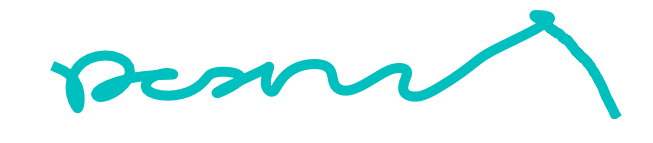

./saved/model.ckpt-124500
INFO:tensorflow:Restoring parameters from ./saved/model.ckpt-124500


/opt/conda/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


loaded model: ./saved/model.ckpt-124500


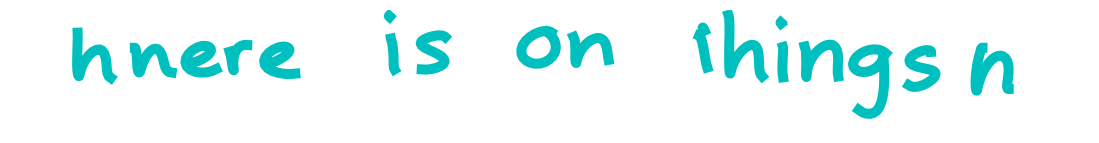

./saved/model.ckpt-124500
INFO:tensorflow:Restoring parameters from ./saved/model.ckpt-124500
loaded model: ./saved/model.ckpt-124500


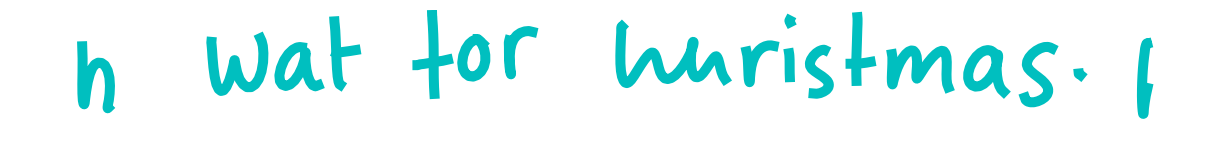

./saved/model.ckpt-124500
INFO:tensorflow:Restoring parameters from ./saved/model.ckpt-124500
loaded model: ./saved/model.ckpt-124500


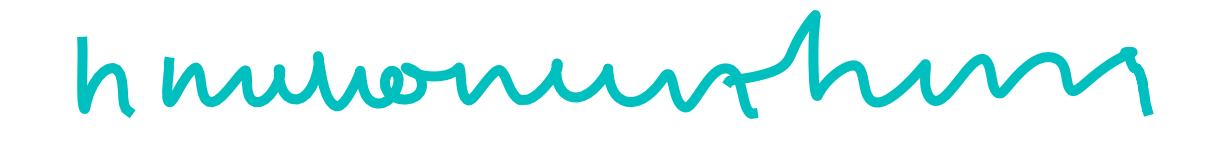

./saved/model.ckpt-124500
INFO:tensorflow:Restoring parameters from ./saved/model.ckpt-124500
loaded model: ./saved/model.ckpt-124500


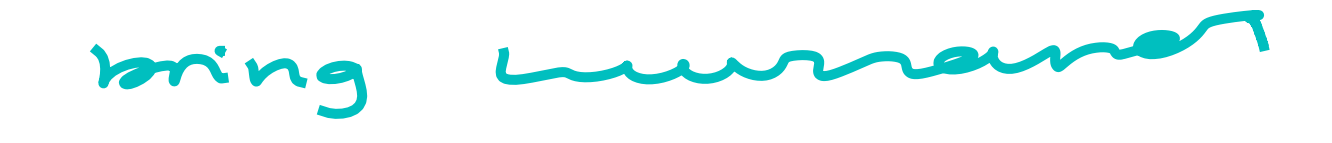

./saved/model.ckpt-124500
INFO:tensorflow:Restoring parameters from ./saved/model.ckpt-124500
loaded model: ./saved/model.ckpt-124500


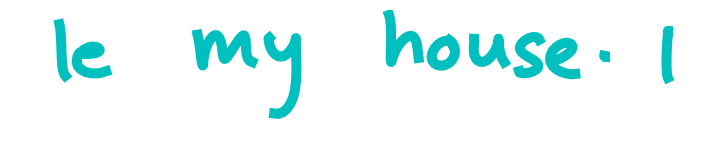

./saved/model.ckpt-124500
INFO:tensorflow:Restoring parameters from ./saved/model.ckpt-124500
loaded model: ./saved/model.ckpt-124500


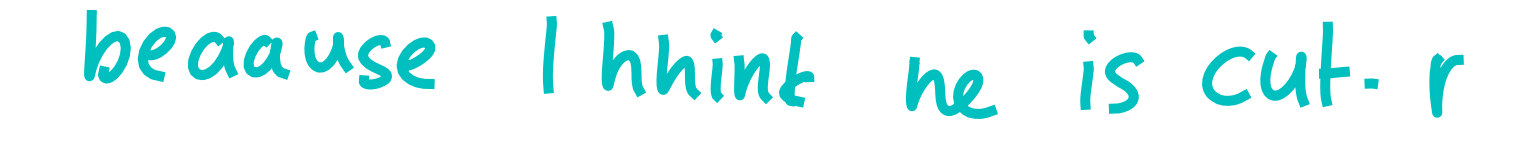

./saved/model.ckpt-124500
INFO:tensorflow:Restoring parameters from ./saved/model.ckpt-124500
loaded model: ./saved/model.ckpt-124500


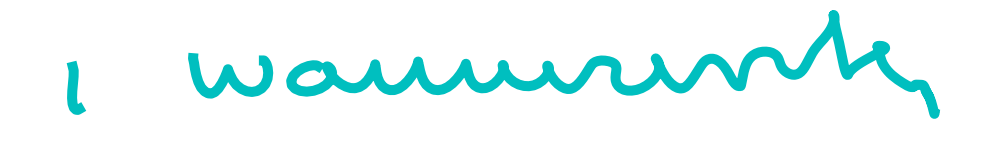

./saved/model.ckpt-124500
INFO:tensorflow:Restoring parameters from ./saved/model.ckpt-124500
loaded model: ./saved/model.ckpt-124500


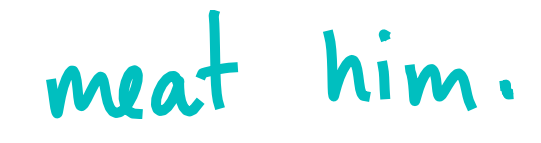

./saved/model.ckpt-124500
INFO:tensorflow:Restoring parameters from ./saved/model.ckpt-124500
loaded model: ./saved/model.ckpt-124500


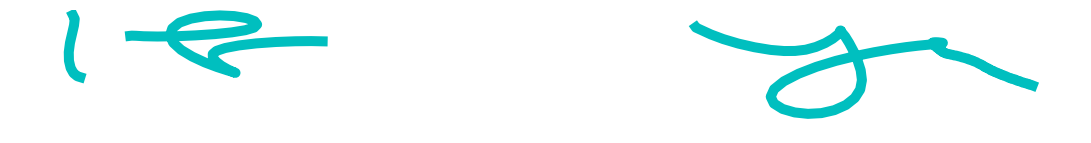

./saved/model.ckpt-124500
INFO:tensorflow:Restoring parameters from ./saved/model.ckpt-124500
loaded model: ./saved/model.ckpt-124500


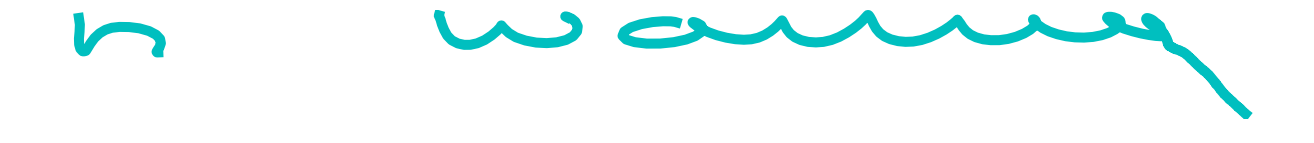

./saved/model.ckpt-124500
INFO:tensorflow:Restoring parameters from ./saved/model.ckpt-124500
loaded model: ./saved/model.ckpt-124500


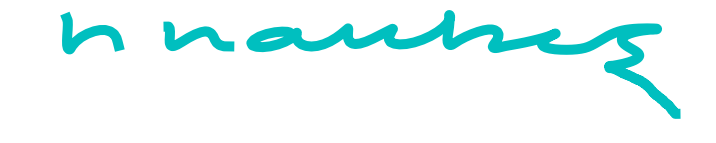

In [11]:
for kk in range(len(line)):
    
    tf.reset_default_graph()
    args = FakeArgParse()

    #general model params
    args.train = False
    args.rnn_size = 100 #400 hidden units
    args.tsteps = 256 if args.train else 1
    args.batch_size = 32 if args.train else 1
    args.nmixtures = 8 # number of Gaussian mixtures in MDN

    #window params
    args.kmixtures = 1 # number of Gaussian mixtures in attention mechanism (for soft convolution window)
    args.alphabet = ' abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ' #later we'll add an <UNK> slot for unknown chars
    args.tsteps_per_ascii = 25 # an approximate estimate

    #book-keeping
    args.save_path = './saved/model.ckpt'
    args.data_dir = './data'
    args.log_dir = './logs/'

    args.style = -1 # don't use a custom style
    #args.bias = 4.0 # Santa 4
    args.bias = 3.0 # Santa 3
    #args.bias = 2.0 # Santa 2
    #args.bias = 1.0 # Santa 1
    args.eos_prob = 0.4 # threshold probability for ending a stroke


    model = FakeModel()

    args.text = line[kk]
    model.char_vec_len = len(args.alphabet) + 1 #plus one for <UNK> token
    model.ascii_steps = len(args.text)

    model.graves_initializer = tf.truncated_normal_initializer(mean=0., stddev=.075, seed=None, dtype=tf.float32)
    model.window_b_initializer = tf.truncated_normal_initializer(mean=-3.0, stddev=.25, seed=None, dtype=tf.float32)


    # ----- build the basic recurrent network architecture
    cell_func = tf.contrib.rnn.LSTMCell # could be GRUCell or RNNCell
    model.cell0 = cell_func(args.rnn_size, state_is_tuple=True, initializer=model.graves_initializer)
    model.cell1 = cell_func(args.rnn_size, state_is_tuple=True, initializer=model.graves_initializer)
    model.cell2 = cell_func(args.rnn_size, state_is_tuple=True, initializer=model.graves_initializer)

    model.input_data = tf.placeholder(dtype=tf.float32, shape=[None, args.tsteps, 3])
    model.target_data = tf.placeholder(dtype=tf.float32, shape=[None, args.tsteps, 3])
    model.istate_cell0 = model.cell0.zero_state(batch_size=args.batch_size, dtype=tf.float32)
    model.istate_cell1 = model.cell1.zero_state(batch_size=args.batch_size, dtype=tf.float32)
    model.istate_cell2 = model.cell2.zero_state(batch_size=args.batch_size, dtype=tf.float32)

    #slice the input volume into separate vols for each tstep
    inputs = [tf.squeeze(input_, [1]) for input_ in tf.split(model.input_data, args.tsteps, 1)]

    #build model.cell0 computational graph
    outs_cell0, model.fstate_cell0 = tf.contrib.legacy_seq2seq.rnn_decoder(inputs, model.istate_cell0, \
                                                           model.cell0, loop_function=None, scope='cell0')



    model.init_kappa = tf.placeholder(dtype=tf.float32, shape=[None, args.kmixtures, 1]) 
    model.char_seq = tf.placeholder(dtype=tf.float32, shape=[None, model.ascii_steps, model.char_vec_len])
    wavg_prev_kappa = model.init_kappa
    prev_window = model.char_seq[:,0,:]

    #add gaussian window result
    reuse = False
    for i in range(len(outs_cell0)):
        [alpha, beta, new_kappa] = get_window_params(i, outs_cell0[i], args.kmixtures, wavg_prev_kappa, reuse=reuse)
        window, phi = get_window(alpha, beta, new_kappa, model.char_seq)
        outs_cell0[i] = tf.concat((outs_cell0[i],window), 1) #concat outputs
        outs_cell0[i] = tf.concat((outs_cell0[i],inputs[i]), 1) #concat input data
    #         prev_kappa = new_kappa #tf.ones_like(new_kappa, dtype=tf.float32, name="prev_kappa_ones") #
        wavg_prev_kappa = tf.reduce_mean( new_kappa, reduction_indices=1, keep_dims=True) # mean along kmixtures dimension
        reuse = True
    model.window = window #save the last window (for generation)
    model.phi = phi #save the last window (for generation)
    model.new_kappa = new_kappa #save the last window (for generation)
    model.alpha = alpha #save the last window (for generation)
    model.wavg_prev_kappa = wavg_prev_kappa




    # ----- finish building second recurrent cell
    outs_cell1, model.fstate_cell1 = tf.contrib.legacy_seq2seq.rnn_decoder(outs_cell0, model.istate_cell1, model.cell1, \
                                                        loop_function=None, scope='cell1') #use scope from training

    # ----- finish building third recurrent cell
    outs_cell2, model.fstate_cell2 = tf.contrib.legacy_seq2seq.rnn_decoder(outs_cell1, model.istate_cell2, model.cell2, \
                                                        loop_function=None, scope='cell2')

    out_cell2 = tf.reshape(tf.concat(outs_cell2, 1), [-1, args.rnn_size]) #concat outputs for efficiency




    #put a dense cap on top of the rnn cells (to interface with the mixture density network)
    n_out = 1 + args.nmixtures * 6 # params = end_of_stroke + 6 parameters per Gaussian
    with tf.variable_scope('mdn_dense'):
        output_w = tf.get_variable("output_w", [args.rnn_size, n_out], initializer=model.graves_initializer)
        output_b = tf.get_variable("output_b", [n_out], initializer=model.graves_initializer)

    output = tf.nn.xw_plus_b(out_cell2, output_w, output_b) #data flows through dense nn




    # reshape target data (as we did the input data)
    flat_target_data = tf.reshape(model.target_data,[-1, 3])
    [x1_data, x2_data, eos_data] = tf.split(flat_target_data, 3, 1) #we might as well split these now
    [model.eos, model.pi, model.mu1, model.mu2, model.sigma1, model.sigma2, model.rho] = get_mdn_coef(output)



    model.sess = tf.InteractiveSession()
    model.saver = tf.train.Saver(tf.global_variables())
    model.sess.run(tf.global_variables_initializer())

    load_was_success = True # yes, I'm being optimistic
    global_step = 0
    try:
        save_dir = '/'.join(args.save_path.split('/')[:-1])
        ckpt = tf.train.get_checkpoint_state(save_dir)
        load_path = ckpt.model_checkpoint_path
        print(load_path)
        model.saver.restore(model.sess, load_path)
    except:
        print("no saved model to load. starting new session")
        load_was_success = False
    else:
        print("loaded model: {}".format(load_path))
        model.saver = tf.train.Saver(tf.global_variables())
        global_step = int(load_path.split('-')[-1])


    # initialize some sampling parameters
    one_hot = [to_one_hot(args.text, model.ascii_steps, args.alphabet)]  # convert input string to one-hot vector
    [c0, c1, c2, h0, h1, h2] = get_style_states(model, args)              # get numpy zeros states for all three LSTMs
    kappa = np.zeros((1, args.kmixtures, 1))                              # attention's read head starts at index 0
    prev_x = np.asarray([[[0, 0, 1]]], dtype=np.float32)                  # start with a pen stroke at (0,0)

    strokes, pis, windows, phis, kappas = [], [], [], [], []              # the data we're going to generate will go here    




    finished = False ; i = 0
    while not finished and i < 800:
        feed = {model.input_data: prev_x, model.char_seq: one_hot, model.init_kappa: kappa, \
                model.istate_cell0.c: c0, model.istate_cell1.c: c1, model.istate_cell2.c: c2, \
                model.istate_cell0.h: h0, model.istate_cell1.h: h1, model.istate_cell2.h: h2}
        fetch = [model.pi_hat, model.mu1, model.mu2, model.sigma1_hat, model.sigma2_hat, model.rho, model.eos, \
                 model.window, model.phi, model.new_kappa, model.wavg_prev_kappa, model.alpha, \
                 model.fstate_cell0.c, model.fstate_cell1.c, model.fstate_cell2.c,\
                 model.fstate_cell0.h, model.fstate_cell1.h, model.fstate_cell2.h]
        [pi_hat, mu1, mu2, sigma1_hat, sigma2_hat, rho, eos, window, phi, kappa, wavg_kappa, alpha, \
                 c0, c1, c2, h0, h1, h2] = model.sess.run(fetch, feed)

        #bias stuff:
        sigma1 = np.exp(sigma1_hat - args.bias)
        sigma2 = np.exp(sigma2_hat - args.bias)
        pi_hat *= 1 + args.bias # apply bias
        pi = np.zeros_like(pi_hat) # need to preallocate
        pi[0] = np.exp(pi_hat[0]) / np.sum(np.exp(pi_hat[0]), axis=0) # softmax

        # choose a component from the MDN
        idx = np.random.choice(pi.shape[1], p=pi[0])
        eos = 1 if args.eos_prob < eos[0][0] else 0 # use 0.5 as arbitrary boundary
        x1, x2 = sample_gaussian2d(mu1[0][idx], mu2[0][idx], sigma1[0][idx], sigma2[0][idx], rho[0][idx])

        # store the info at this time step
        windows.append(window)
        phis.append(phi[0])
        kappas.append(kappa[0])
        pis.append(pi[0])
        strokes.append([mu1[0][idx], mu2[0][idx], sigma1[0][idx], sigma2[0][idx], rho[0][idx], eos])

        # test if finished (has the read head seen the whole ascii sequence?)
        main_kappa_idx = np.where(alpha[0]==np.max(alpha[0])); # choose the read head with the highes alpha value
        finished = True if kappa[0][main_kappa_idx] > len(args.text) + 1 else False

        # new input is previous output
        prev_x[0][0] = np.array([x1, x2, eos], dtype=np.float32)
        kappa = wavg_kappa
        i+=1

    windows = np.vstack(windows)
    phis = np.vstack(phis)
    kappas = np.vstack(kappas)
    pis = np.vstack(pis)
    strokes = np.vstack(strokes)

    # the network predicts the displacements between pen points, so do a running sum over the time dimension
    strokes[:,:2] = np.cumsum(strokes[:,:2], axis=0)



    line_plot(strokes, 'Line plot: "{}"'.format(args.text), args.text, figsize=(model.ascii_steps,2))

